# IKpy Quickstart #

Import the IKPy module : 

In [1]:
import ikpy.chain
import numpy as np
import ikpy.utils.plot as plot_utils

The basic element of IKPy is the kinematic `Chain`.
To create a chain from an URDF file : 

In [2]:
my_chain = ikpy.chain.Chain.from_urdf_file("./ur5/ur5_gripper.urdf")

C:\Users\Willo\OneDrive\Documents\Robotics\lab-2-ik\.pixi\envs\default\Lib\site-packages\ikpy\chain.py:60: UserWarning: Link Base link (index: 0) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive".format(link.name, link_index))
C:\Users\Willo\OneDrive\Documents\Robotics\lab-2-ik\.pixi\envs\default\Lib\site-packages\ikpy\chain.py:60: UserWarning: Link ee_fixed_joint (index: 7) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it

# Inverse kinematics

In Inverse Kinematics, you want your kinematic chain to reach a 3D position in space.

To have a more general representation of position, IKPy works with homogeneous coordinates. Homogenous coordinates are represented as a 4x4 matrix storing both position and orientation. Here we only consider (x,y,z) position, not orientation of the chain.

In [3]:
target_position = [ 1, 0, 0] # .1, -.2, .1

In [4]:
print("The joint angles are : ", my_chain.inverse_kinematics(target_position))

The joint angles are :  [ 0.00000000e+00 -1.33311211e-01  8.97060634e-02  1.39081864e-05
 -8.65349546e-01  1.36753880e+00  0.00000000e+00  0.00000000e+00]


You can check that the Inverse Kinematics is correct by comparing with the original position vector : 

In [5]:
real_frame = my_chain.forward_kinematics(my_chain.inverse_kinematics(target_position))
print("Computed position vector : %s, goal position vector : %s" % (real_frame[:3, 3], target_position))

Computed position vector : [ 9.46180329e-01 -1.51658255e-08  4.79874303e-03], goal position vector : [1, 0, 0]


# Plotting
And finally plot the result : 

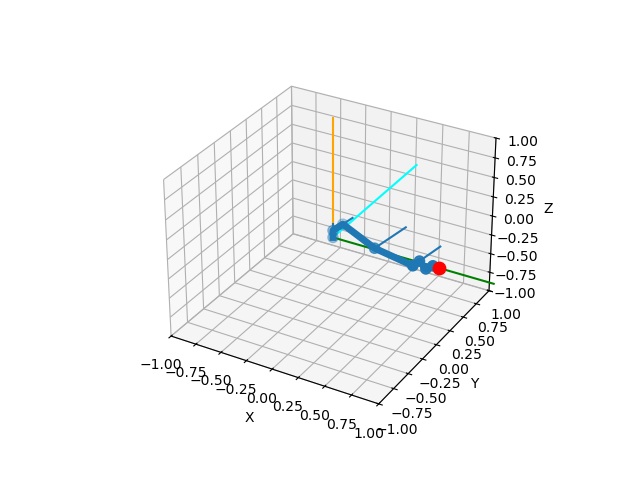

In [6]:
%matplotlib notebook
%matplotlib ipympl

import matplotlib.pyplot as plt
fig, ax = plot_utils.init_3d_figure()
my_chain.plot(my_chain.inverse_kinematics(target_position), ax, target=target_position)


[[ 0.64596537  1.02250852 -0.88724578]
 [ 0.28193697  1.47324648 -0.00750629]
 [-0.26851418 -0.15770526  1.46732041]
 [-1.25904952 -0.33335521  0.74408911]
 [ 1.29632075 -0.50485117 -0.5609615 ]
 [ 0.88240399  0.88130347  0.8334671 ]
 [ 0.57482331 -1.36675036  0.22709382]
 [ 1.07286193 -0.03618327  1.04769177]
 [ 0.98818788 -0.45355874  1.03332918]
 [ 0.10125589 -0.2618765   1.47348836]]


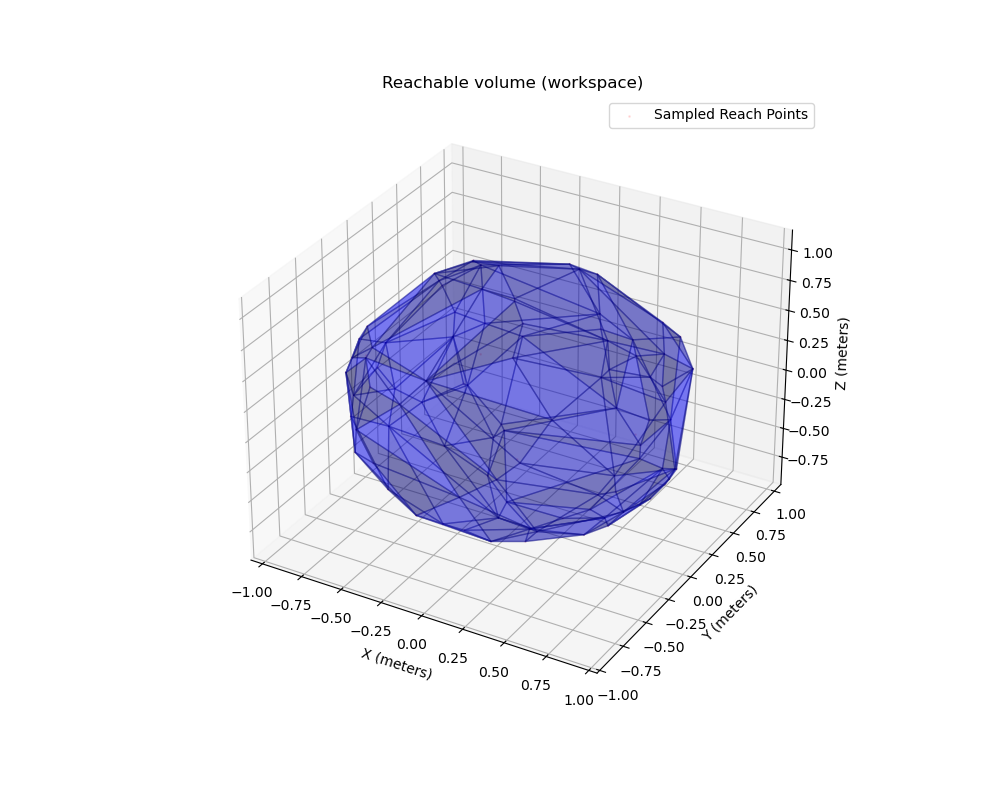

In [7]:
from scipy.spatial import ConvexHull

# sampled_points array of shape (N, 3) 
# representing points on a sphere around the robot.

n = 100
radius = 1.5

coords = np.random.randn(n, 3)
mag = np.linalg.norm(coords, axis=1)
sampled_points = coords / mag[:, np.newaxis] * radius

print(sampled_points[:10])

# calc reachable points
# attempt to reach each sampled point and record where the tip actually ends up
reached_points = []
for target in sampled_points:
    # inverse kinematics to find joint angles
    ik_solution = my_chain.inverse_kinematics(target)
    
    # forward kinematics to find the actual position reached
    # FK returns a 4x4 matrix, the first 3 elements of the last column are (x, y, z)
    actual_pos = my_chain.forward_kinematics(ik_solution)[:3, 3]
    reached_points.append(actual_pos)

reached_points = np.array(reached_points)

# compute convex hull of the reached points to help visualize the outer boundary of the robot's workspace.
hull = ConvexHull(reached_points)

# - visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# plot individual points
ax.scatter(reached_points[:,0], reached_points[:,1], reached_points[:,2], 
           c='red', alpha=0.1, s=1, label='Sampled Reach Points')

# plot convex hull
# hull.simplices contains the triplets of indices that form triangles on the surface
ax.plot_trisurf(reached_points[:,0], reached_points[:,1], reached_points[:,2], 
                triangles=hull.simplices, color='blue', alpha=0.3, edgecolor='navy')

ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_zlabel('Z (meters)')
ax.set_title('Reachable volume (workspace)')
ax.legend()

plt.show()

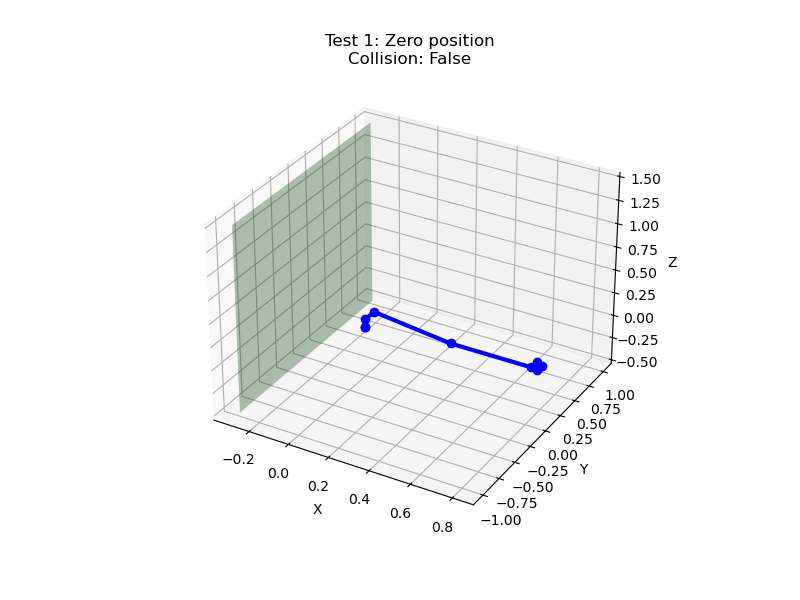

Test 1 (Zero position): Collision = False


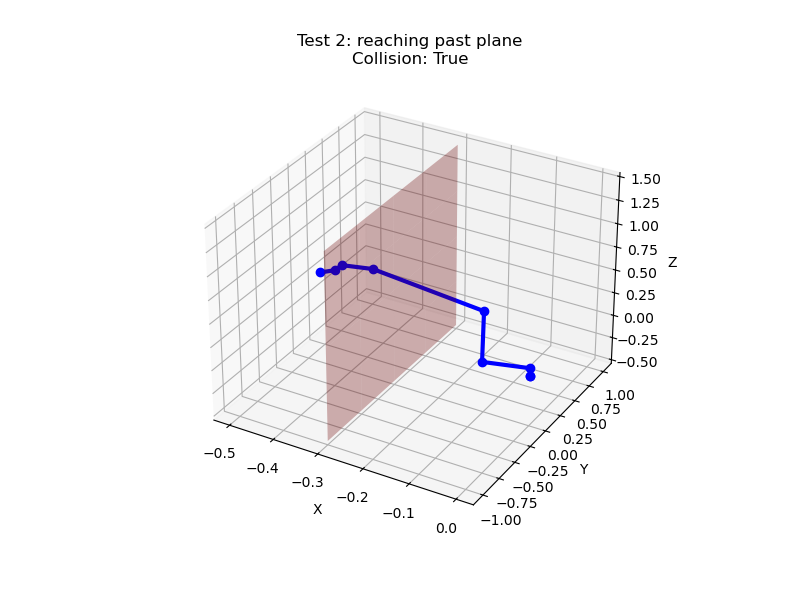

Test 2 (Reach to x=-0.5): Collision = True


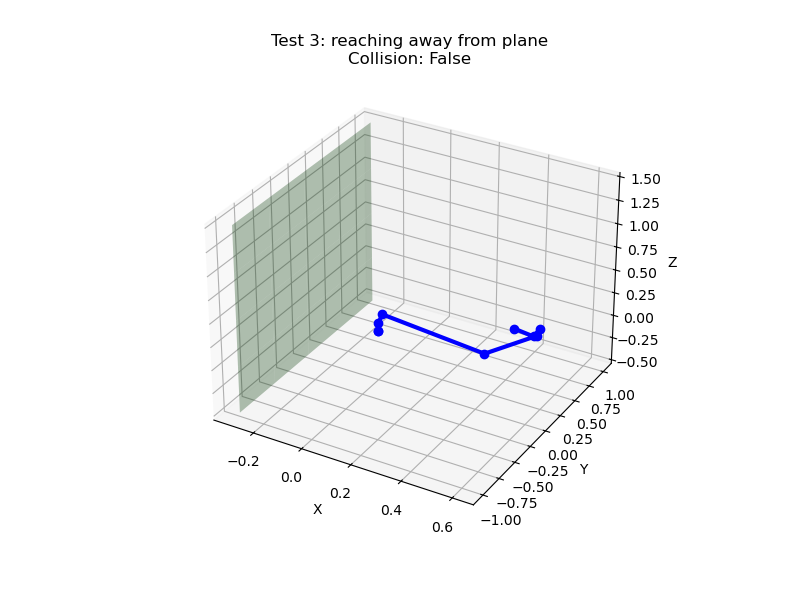

Test 3 (Reach to x=0.5): Collision = False


In [8]:
# part 3: collision checking

PLANE_X = -0.3

def get_joint_positions(chain, angles):
    """get 3D position of each joint in the chain."""
    positions = [[0, 0, 0]]
    transform = np.eye(4)
    for i, link in enumerate(chain.links):
        # use angle for this joint (or 0 if it's fixed link)
        angle = angles[i] if i < len(angles) else 0
        transform = transform @ link.get_link_frame_matrix(angle)
        positions.append(transform[:3, 3].copy())
    return np.array(positions)

def check_collision(chain, angles):
    """check if any part of arm crosses plane"""
    positions = get_joint_positions(chain, angles)
    for i in range(len(positions) - 1):
        x1, x2 = positions[i][0], positions[i+1][0]
        # if one point is on each side of plane, collision
        if (x1 - PLANE_X) * (x2 - PLANE_X) < 0:
            return True
    return False

def visualize(chain, angles, title):
    """visualize robot and plane."""
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # arm
    pos = get_joint_positions(chain, angles)
    ax.plot(pos[:,0], pos[:,1], pos[:,2], 'b-o', linewidth=3, markersize=6)
    
    # plane
    Y, Z = np.meshgrid(np.linspace(-1, 1, 5), np.linspace(-0.5, 1.5, 5))
    X = np.ones_like(Y) * PLANE_X
    color = 'red' if check_collision(chain, angles) else 'green'
    ax.plot_surface(X, Y, Z, alpha=0.3, color=color)
    
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f"{title}\nCollision: {check_collision(chain, angles)}")
    plt.show()

#TEST

# test 1: zero position - shouldn't collide
angles1 = [0] * len(my_chain.links)
visualize(my_chain, angles1, "Test 1: Zero position")
print(f"Test 1 (Zero position): Collision = {check_collision(my_chain, angles1)}")

# Test 2: reach past plane - should collide
angles2 = my_chain.inverse_kinematics([-0.5, 0.2, 0.3])
visualize(my_chain, angles2, "Test 2: reaching past plane")
print(f"Test 2 (Reach to x=-0.5): Collision = {check_collision(my_chain, angles2)}")

# Test 3: reach away from plane - should not collide
angles3 = my_chain.inverse_kinematics([0.5, 0.2, 0.3])
visualize(my_chain, angles3, "Test 3: reaching away from plane")
print(f"Test 3 (Reach to x=0.5): Collision = {check_collision(my_chain, angles3)}")

In [9]:
# Part 4
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import imageio

waypoints = [
    [0.3, 0.0, 0.5],
    [0.1, 0.2, 0.4],
    [-0.1, 0.3, 0.3],
    [-0.2, 0.3, 0.2],
]

def interpolate_waypoints(waypoints, steps=20):
    all_points = []
    for i in range(len(waypoints) - 1):
        for t in np.linspace(0, 1, steps):
            all_points.append(np.array(waypoints[i]) + t * (np.array(waypoints[i+1]) - np.array(waypoints[i])))
    return all_points

# gen trajectory
trajectory = interpolate_waypoints(waypoints, steps=25)

# compute angles
angles_list = []
prev = [0] * len(my_chain.links)
for target in trajectory:
    angles = my_chain.inverse_kinematics(target, initial_position=prev)
    angles_list.append(angles)
    prev = angles

# plane
plane_verts = [[[PLANE_X, -1, -0.5], [PLANE_X, 1, -0.5], [PLANE_X, 1, 1.5], [PLANE_X, -1, 1.5]]]

# make video
frames = []
print("generating video...")

for i, angles in enumerate(angles_list):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    pos = get_joint_positions(my_chain, angles)
    ax.plot(pos[:,0], pos[:,1], pos[:,2], 'b-o', linewidth=3, markersize=5)
    ax.add_collection3d(Poly3DCollection(plane_verts, alpha=0.3, facecolor='green'))
    ax.scatter(*trajectory[i], c='red', s=40, marker='*')
    
    ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-0.5, 1.5)
    ax.view_init(elev=20, azim=45)
    ax.set_title(f'Frame {i+1}/{len(angles_list)}')
    
    fig.canvas.draw()
    # approach that works on all backends?
    image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    
    # convert RGBA to RGB
    frames.append(image_from_plot[:, :, :3])
    
    plt.close(fig)

imageio.mimsave('robot_trajectory.mp4', frames, fps=15)
print("saved as robot_trajectory.mp4")

# restore backend
matplotlib.use('module://ipympl.backend_nbagg')

Generating video...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 500) to (608, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done! Saved as robot_trajectory.mp4
